In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
import pybaseball
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


In [2]:
pybaseball.cache.enable()

In [4]:
data = pybaseball.statcast(start_dt = "2023-06-13", end_dt = "2025-05-05")

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 454/454 [00:42<00:00, 10.79it/s]
c:\Users\silva\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybaseball\statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [47]:
for name in data.columns:
    print(name)

pitch_type
game_date
release_speed
release_pos_x
release_pos_z
player_name
batter
pitcher
events
description
spin_dir
spin_rate_deprecated
break_angle_deprecated
break_length_deprecated
zone
des
game_type
stand
p_throws
home_team
away_team
type
hit_location
bb_type
balls
strikes
game_year
pfx_x
pfx_z
plate_x
plate_z
on_3b
on_2b
on_1b
outs_when_up
inning
inning_topbot
hc_x
hc_y
tfs_deprecated
tfs_zulu_deprecated
umpire
sv_id
vx0
vy0
vz0
ax
ay
az
sz_top
sz_bot
hit_distance_sc
launch_speed
launch_angle
effective_speed
release_spin_rate
release_extension
game_pk
fielder_2
fielder_3
fielder_4
fielder_5
fielder_6
fielder_7
fielder_8
fielder_9
release_pos_y
estimated_ba_using_speedangle
estimated_woba_using_speedangle
woba_value
woba_denom
babip_value
iso_value
launch_speed_angle
at_bat_number
pitch_number
pitch_name
home_score
away_score
bat_score
fld_score
post_away_score
post_home_score
post_bat_score
post_fld_score
if_fielding_alignment
of_fielding_alignment
spin_axis
delta_home_win_exp
d

In [157]:
filtered_data = data[["pitcher",
                      "pitch_type",
                      "batter",
                      "events",
                      "zone",
                      "p_throws",
                      "release_spin_rate",
                      "release_speed",
                      "launch_speed",
                      "launch_angle",
                      "release_pos_x",
                      "release_pos_y",
                      "release_pos_z",
                      "plate_x",
                      "plate_z",
                      "pfx_x",
                      "stand"
                      ]]

In [158]:
filtered_data = filtered_data.dropna(subset=["events"])
filtered_data = filtered_data.fillna(0)
#Dropping Certain Events
dropped_events = ["fielders_choice","fielders_choice_out",'catcher_interf','double_play','force_out','grounded_into_double_play','sac_fly_double_play','strikeout_double_play','triple_play',None]
for event in dropped_events:
    index= (filtered_data[(filtered_data["events"] == event)]).index
    filtered_data.drop(index,inplace= True)
#Dropping Pitchtype 0
index = (filtered_data[(filtered_data["pitch_type"] == 0)]).index
filtered_data.drop(index,inplace = True)
filtered_data.head()

,pitcher,pitch_type,batter,events,zone,p_throws,release_spin_rate,release_speed,launch_speed,launch_angle,release_pos_x,release_pos_y,release_pos_z,plate_x,plate_z,pfx_x,stand
4652,621242,FF,650968,single,11,R,2337,96.2,92.8,12,-2.28,53.6,4.86,-1.43,3.24,-1.04,R
4579,592773,FF,676480,field_out,11,R,2292,97.7,74.7,69,-0.37,54.63,6.69,-0.14,3.89,-0.66,R
4401,700241,ST,668901,strikeout,7,R,2491,84.2,0.0,0,-2.44,53.68,5.67,-0.43,1.6,0.91,R
4216,656731,SL,680977,field_out,13,R,2497,84.1,96.5,21,-2.98,53.84,6.01,-0.91,2.19,0.39,L
4738,656731,FF,663457,field_out,11,R,2158,92.9,101.1,43,-2.93,53.47,6.02,-0.43,3.72,-0.68,L


In [159]:
events = filtered_data["pitch_type"].unique()
print(events)

['FF' 'ST' 'SL' 'FS' 'FC' 'SI' 'CU' 'CH' 'KC' 'EP' 'FA' 'SV' 'FO' 'KN'
 'SC']


In [160]:
le = LabelEncoder()
filtered_data["p_throws"] = le.fit_transform(filtered_data["p_throws"])
filtered_data["pitch_type"] = le.fit_transform(filtered_data["pitch_type"])
filtered_data["stand"] = le.fit_transform(filtered_data["p_throws"])
filtered_data["events"] = le.fit_transform(filtered_data["events"])


In [161]:
#Get name mappings
le_name_mapping = dict(zip(le.classes_,le.transform(le.classes_)))
print(le_name_mapping)

{'double': 0, 'field_error': 1, 'field_out': 2, 'hit_by_pitch': 3, 'home_run': 4, 'sac_bunt': 5, 'sac_fly': 6, 'single': 7, 'strikeout': 8, 'triple': 9, 'truncated_pa': 10, 'walk': 11}


In [162]:
y = filtered_data[["events"]]
x = filtered_data.drop("events",axis = 1)

In [108]:
#Attempting to see if PCA on our data set is a good idea before feeding into our model
pca = PCA()
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
pca.fit(x_scaled)
x_pca = pca.transform(x_scaled)
pca.explained_variance_ratio_

array([2.88271445e-01, 2.36796567e-01, 1.09175071e-01, 7.91497924e-02,
       7.82477379e-02, 7.41938046e-02, 4.68010186e-02, 3.34344584e-02,
       2.67530973e-02, 1.36475997e-02, 9.10062567e-03, 4.42878172e-03,
       2.50851915e-17])

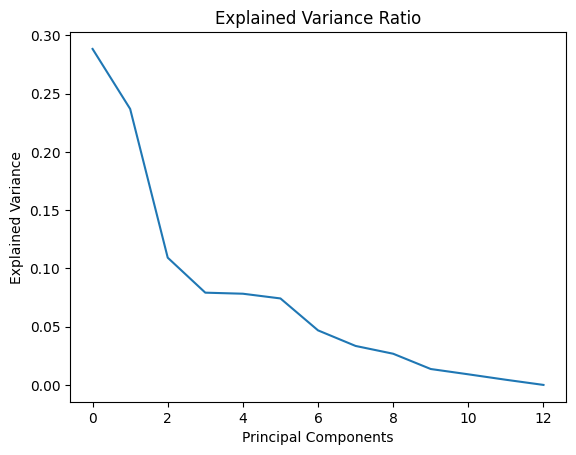

[2.88271445e-01 2.36796567e-01 1.09175071e-01 7.91497924e-02
 7.82477379e-02 7.41938046e-02 4.68010186e-02 3.34344584e-02
 2.67530973e-02 1.36475997e-02 9.10062567e-03 4.42878172e-03
 2.50851915e-17]


In [109]:
# Plot
plt.plot(range(0,13), pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio')
plt.show()
print(pca.explained_variance_ratio_)

We can conclude that PCA is not a good fit, we would need almost 10 PCs to have a 95%+ explained variance ratio. Since we only have 15 predictors, PCA was not a good fit for dimension reduction for our data set.

<Axes: >

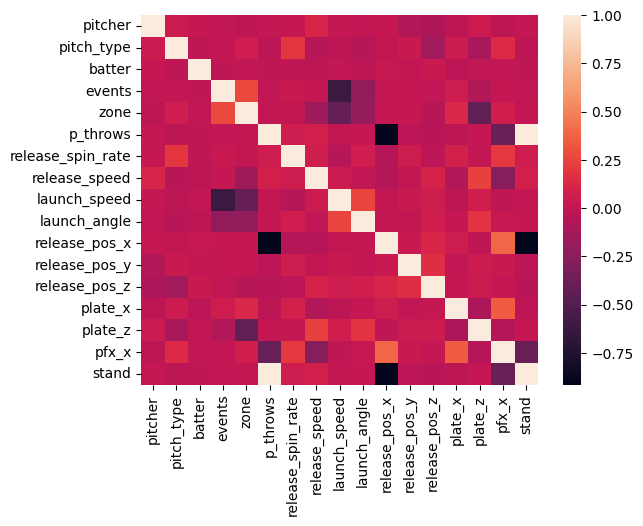

In [163]:
#Plotting Correlation Heatmap 
sns.heatmap(filtered_data.corr())

In [164]:
#Random_state 10
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,shuffle=True)
x_test.shape
x_train.shape

(3733, 16)

In [165]:
#Base Model - This model will be tested against vs models after crossvalidation
base_model = RandomForestClassifier(n_jobs=-1)
base_model.fit(x_train,y_train)
y_pred = base_model.predict(x_test)

c:\Users\silva\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


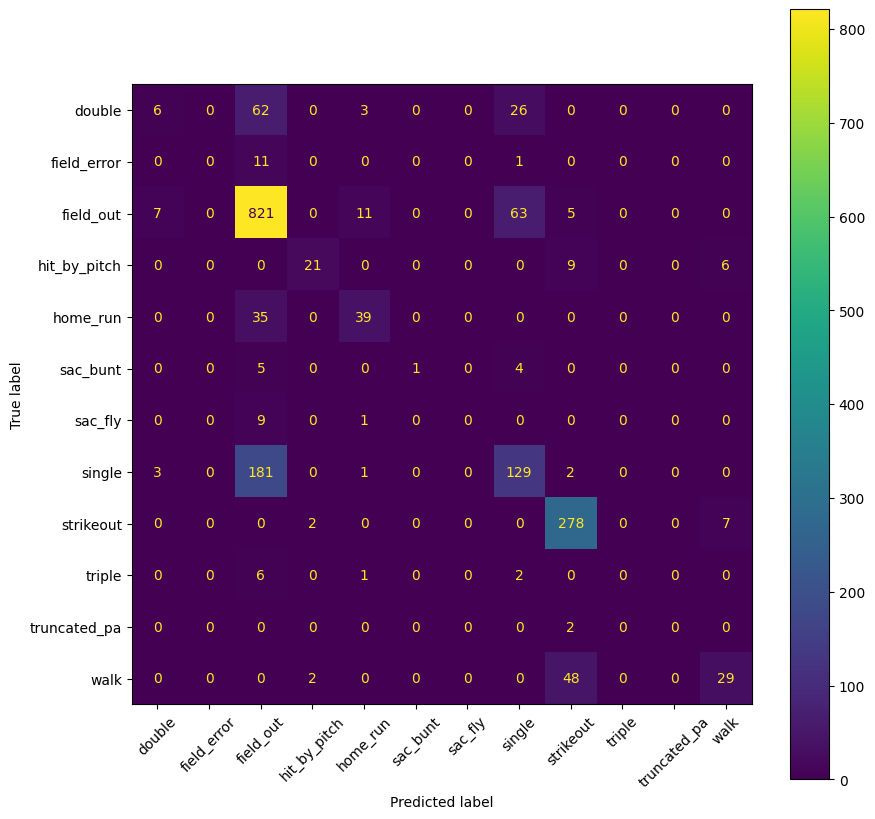

In [166]:
#Make Plots
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix= cm,display_labels=le_name_mapping)
fig,ax = plt.subplots(figsize=(10,10))
disp.plot(ax = ax,xticks_rotation=45)

In [167]:
#Classification Report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.06      0.38      0.11        16
           1       0.00      0.00      0.00         0
           2       0.91      0.73      0.81      1130
           3       0.58      0.84      0.69        25
           4       0.53      0.70      0.60        56
           5       0.10      1.00      0.18         1
           6       0.00      0.00      0.00         0
           7       0.41      0.57      0.48       225
           8       0.97      0.81      0.88       344
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.37      0.69      0.48        42

    accuracy                           0.72      1839
   macro avg       0.33      0.48      0.35      1839
weighted avg       0.82      0.72      0.76      1839



In [115]:
#Feature Importances based on Base Model
importances = base_model.feature_importances_
forest_importances = pd.Series(importances,index = x.columns)
std = np.std([tree.feature_importances_ for tree in base_model.estimators_],axis = 0)


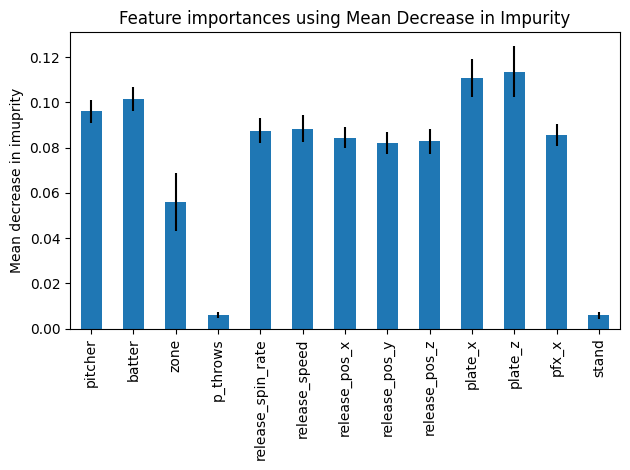

In [116]:
#Feature Importances Plot
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = std, ax = ax)
ax.set_title("Feature importances using Mean Decrease in Impurity")
ax.set_ylabel("Mean decrease in imuprity")
fig.tight_layout()

In [117]:
#Generating RandomSearchCV Parameter grid
params = {"n_estimators": [50,100,150],
          "max_depth": [None,10,20],
          "min_samples_split": [2,5,10],
          "min_samples_leaf":[1,5,10,15],
          "max_features":["sqrt","log2"]
          }

In [118]:
#use Randomsearch
random_search = RandomizedSearchCV(estimator = RandomForestClassifier(n_jobs = -1), 
                           param_distributions=params,
                           scoring="accuracy",
                           n_jobs = -1,
                           verbose = True,
                           cv = 3,
                           n_iter = 2
                          )

#fitting model
random_search.fit(x_train,y_train)


#Print Results
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits


c:\Users\silva\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 10}
Best Score: 0.52038357820597


In [119]:
#Select Best Model based on Hyperparameters chosen by randomizedsearch
best_model = random_search.best_estimator_
best_model.fit(x_train,y_train)

c:\Users\silva\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=10,
                       n_estimators=150, n_jobs=-1)

In [120]:
y_pred = best_model.predict(x_test)

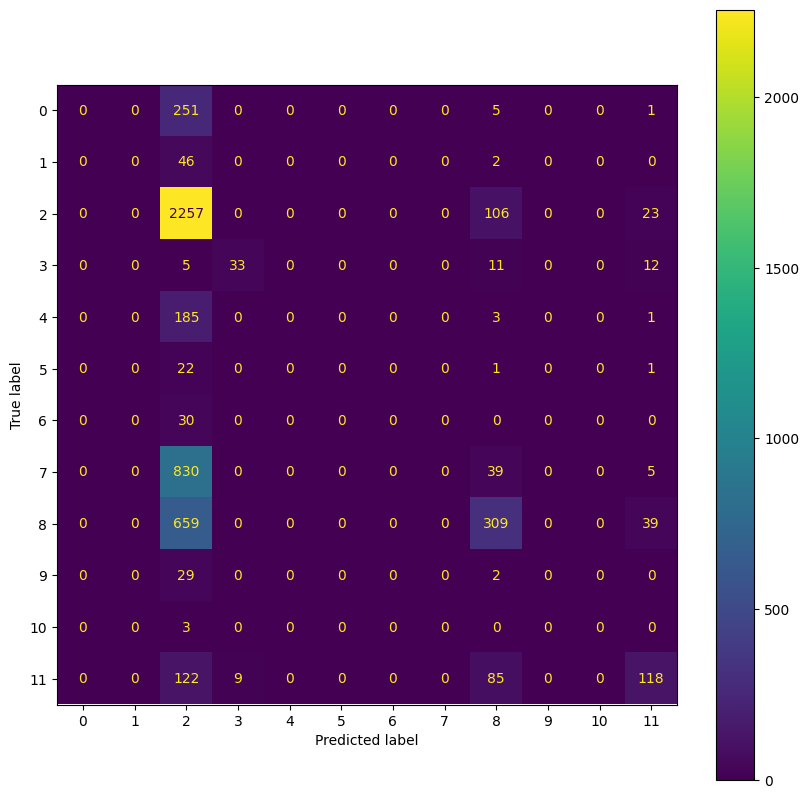

In [124]:

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
fig,ax = plt.subplots(figsize=(10,10))
disp.plot(ax = ax)


In [122]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.95      0.51      0.66      4439
           3       0.54      0.79      0.64        42
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.31      0.55      0.39       563
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.35      0.59      0.44       200

    accuracy                           0.52      5244
   macro avg       0.18      0.20      0.18      5244
weighted avg       0.85      0.52      0.62      5244



In [25]:
importances = best_model.feature_importances_
forest_importances = pd.Series(importances,index = x.columns)
std = np.std([tree.feature_importances_ for tree in best_model.estimators_],axis = 0)

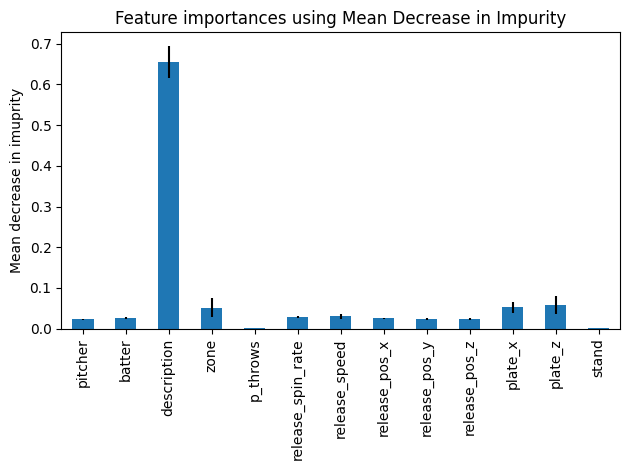

In [26]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = std, ax = ax)
ax.set_title("Feature importances using Mean Decrease in Impurity")
ax.set_ylabel("Mean decrease in imuprity")
fig.tight_layout()